In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
from matplotlib import pyplot as plt
os.chdir(r"W:\My Documents\Mentee @ Amazon\Forecasting\Project ARIMA")
import statsmodels.api as sm


# Simple Exponential Smoothing- COVID Infections


In [2]:
#reading number of people aged 18 to 49 infected by month
infection_agegrp = pd.read_csv("COVID-19_Infections.csv", parse_dates=['case_month'], index_col=['case_month'])\
    .query('age_group == "18 to 49 years"').rename(columns={'sex':'infections'})
infection_agegrp= infection_agegrp.asfreq(pd.infer_freq(infection_agegrp.index))
infection_agegrp.head()


,res_state,age_group,infections
case_month,,,
2020-03-01,TX,18 to 49 years,1426
2020-04-01,TX,18 to 49 years,11353
2020-05-01,TX,18 to 49 years,17813
2020-06-01,TX,18 to 49 years,79797
2020-07-01,TX,18 to 49 years,176188


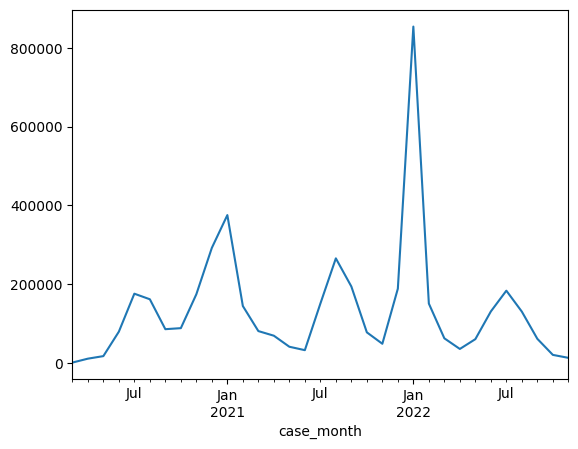

In [3]:
infection_agegrp1 = infection_agegrp.infections
infection_agegrp1.plot();

Train the Model (estimate)

In [4]:

# Test train split
len_train = int(infection_agegrp1.size*0.8)
Y_train = infection_agegrp1[:len_train] #upper limit not included
Y_test = infection_agegrp1[len_train:] #lower limit included


In [53]:
#fit simple exponential smoothing model
Seasonalityadd = sm.tsa.ExponentialSmoothing(Y_train, trend='add', seasonal='add').fit()
Seasonalitymul = sm.tsa.ExponentialSmoothing(Y_train, trend='mul', seasonal= 'mul').fit()
Seasonalityadd_damptrend = sm.tsa.ExponentialSmoothing(Y_train, trend='add', damped_trend=True, seasonal='add').fit()

c:\Users\pudasasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\pudasasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\pudasasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# Generate Foreacasts and measure accuracy

In [6]:
pred_Seasonalityadd = Seasonalityadd.forecast(len(Y_test))
pred_Seasonalitymul = Seasonalitymul.forecast(len(Y_test))
pred_Seasonalityadd_damptrend = Seasonalityadd_damptrend.forecast(len(Y_test))

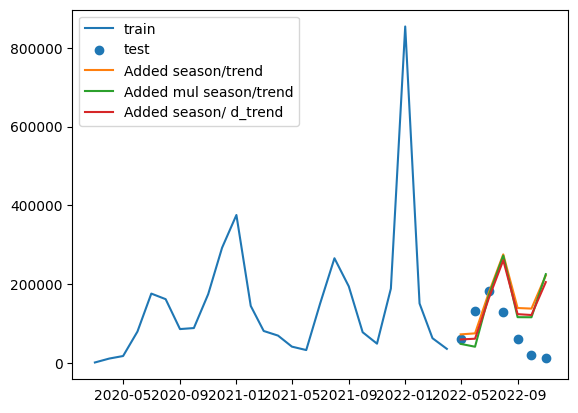

In [7]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
ax.plot(Y_train, label = 'train')
ax.scatter(x= Y_test.index, y= Y_test, label = 'test')
ax.plot(pred_Seasonalityadd, label = 'Added season/trend')
ax.plot(pred_Seasonalitymul, label = 'Added mul season/trend')
ax.plot(pred_Seasonalityadd_damptrend, label = 'Added season/ d_trend')
plt.legend();

In [8]:
def RMSE(Y, y):
    """Root-mean-square error."""
    return np.sqrt(np.mean((Y-y)**2))
def MAE(Y, y):
    """Mean absolute error."""
    return np.mean(np.abs(Y-y))
def MAPE(Y, y):
    """Mean absolute percent error."""
    return 100 * np.mean(np.abs((Y-y)/Y))


In [52]:
#disctionary of prediction values for each model
preds = pred_Seasonalityadd, pred_Seasonalitymul, pred_Seasonalityadd_damptrend
# series of metrices
metrics = RMSE, MAE, MAPE
pd.DataFrame([[f(Y_test,pred) for pred in preds] for f in metrics]
, columns =['additive Season', 'mult. season', 'add season dampd trend']
, index = [f.__name__ for f in metrics ] )



,additive Season,mult. season,add season dampd trend
RMSE,111933.697582,110486.464690,102098.328036
MAE,88743.139335,88130.866888,82055.288034
MAPE,344.802898,331.759341,310.480719


# ARIMA

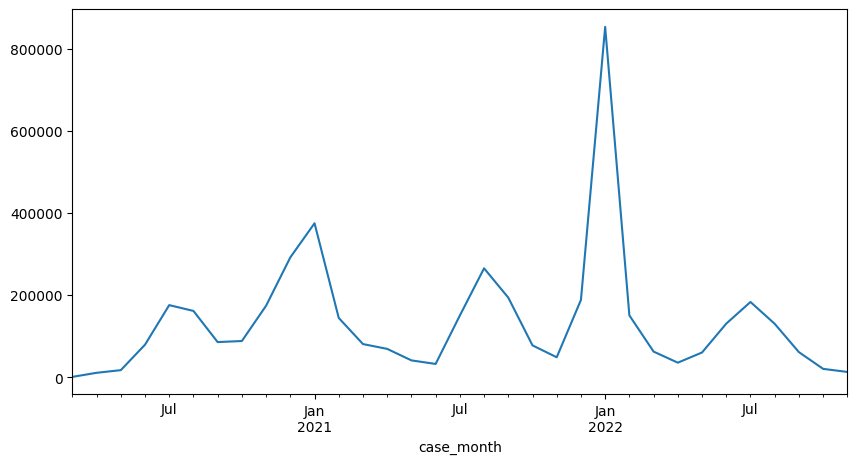

In [54]:
#original plot
infection_agegrp1.plot();

pmdarima will be utliized to select AR(p), MA(q) and differencing (d) for the series

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=356.053, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=362.395, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=355.409, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=353.927, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=355.113, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=357.028, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=354.893, Time=0.04 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=361.532, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=358.438, Time=0.01 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=362.788, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=358.095, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 0.639 seconds


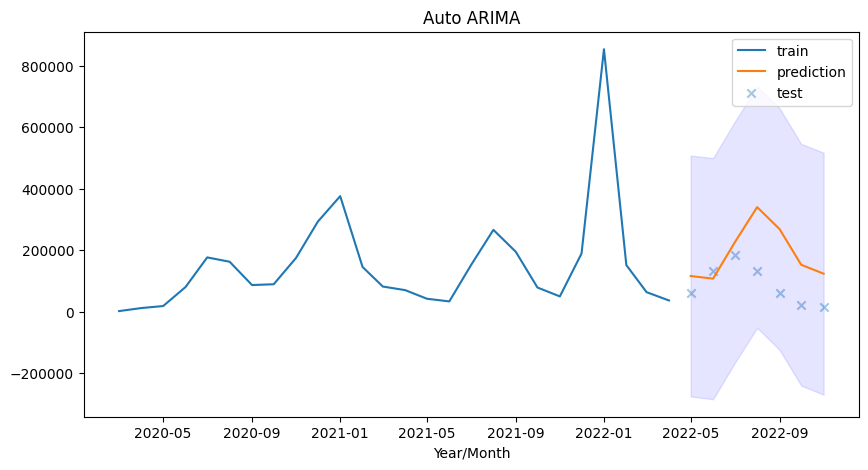

In [75]:
import pmdarima as pm
data = infection_agegrp1
train, test = Y_train, Y_test

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, 
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

# Create predictions for the future, evaluate on test
preds_ARIMA, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# # Print the error:
# print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_years = np.append(train.index, preds.index)
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(train.index, train, label = 'train' )
plt.plot(test.index, preds_ARIMA, label='prediction' )  # Forecasts
plt.scatter(test.index, test,
            alpha=0.4, marker='x', label='test')  # Test data
plt.fill_between(test.index,conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Auto ARIMA")
plt.xlabel("Year/Month")
plt.legend()
plt.show();


In [74]:
MAPE(preds_ARIMA, Y_test)

57.44482122383374

# This MAPE drops down to 8% on a logarithm data, hence is data transformation necessary in expeonential smoothing? Data transformation definlitely looks essential in ARIMA forecasting


In [58]:
#Accuracy metrics with ARIMA
#disctionary of prediction values for each model
preds = pred_Seasonalityadd, pred_Seasonalitymul, pred_Seasonalityadd_damptrend, preds_ARIMA
# series of metrices
metrics = RMSE, MAE, MAPE
pd.DataFrame([[f(Y_test,pred) for pred in preds] for f in metrics]
, columns =['additive Season', 'mult. season', 'add season dampd trend', 'ARIMA']
, index = [f.__name__ for f in metrics ] )

,additive Season,mult. season,add season dampd trend,ARIMA
RMSE,111933.697582,110486.464690,102098.328036,131501.172258
MAE,88743.139335,88130.866888,82055.288034,110989.202848
MAPE,344.802898,331.759341,310.480719,295.448028
